In [1]:
import numpy as np
import matplotlib.pyplot as plt
from core.activations import Fun
from core.losses import LossFun, mse
from core.mlp import MLP
from data.regression import get_regression_data, Size, RegressionType
from utils.normalize import normalize
from utils.split import split_data

# Configuration
layer_sizes = [1, 16, 16, 1]
activations = [Fun.Tanh, Fun.Tanh, Fun.Linear]
loss_funs = [LossFun.MSE, LossFun.MAE] 
task_types = [RegressionType.CUBE, RegressionType.MULTIMODAL, RegressionType.ACTIVATION]

n_repeats = 1
epochs = 3000
learning_rate = 0.01

histories = {}

for task in task_types:
    X, y = get_regression_data(class_type=task, class_size=Size._100)
    Xn, X_mean, X_std = normalize(X)
    Yn, Y_mean, Y_std = normalize(y)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(Xn, Yn)

    for loss in loss_funs:
        runs = []
        for i in range(n_repeats):
            np.random.seed(i)
            mlp = MLP(layer_sizes, activations, loss_fun=loss)
            test_loss = []

            for k in range(epochs//100):
                _, _, _ = mlp.train(
                    X_train, y_train, X_val, y_val, epochs=100, learning_rate=learning_rate
                )
                test_pred = mlp.predict(X_test)
                test_loss.append(mse(y_test, test_pred))

            test_loss = np.array(test_loss)
            runs.append(test_loss)
        histories[(task, loss)] = np.vstack(runs)

Epoka 10/100, błąd treningowy: 0.454421, walidacyjny: 1.378207
Epoka 20/100, błąd treningowy: 0.397505, walidacyjny: 1.155706
Epoka 30/100, błąd treningowy: 0.376557, walidacyjny: 1.031683
Epoka 40/100, błąd treningowy: 0.368180, walidacyjny: 0.959054
Epoka 50/100, błąd treningowy: 0.364214, walidacyjny: 0.914700
Epoka 60/100, błąd treningowy: 0.361813, walidacyjny: 0.886542
Epoka 70/100, błąd treningowy: 0.359984, walidacyjny: 0.867930
Epoka 80/100, błąd treningowy: 0.358375, walidacyjny: 0.855057
Epoka 90/100, błąd treningowy: 0.356862, walidacyjny: 0.845682
Epoka 100/100, błąd treningowy: 0.355399, walidacyjny: 0.838462
Epoka 10/100, błąd treningowy: 0.353970, walidacyjny: 0.832585
Epoka 20/100, błąd treningowy: 0.352566, walidacyjny: 0.827553
Epoka 30/100, błąd treningowy: 0.351184, walidacyjny: 0.823061
Epoka 40/100, błąd treningowy: 0.349822, walidacyjny: 0.818921
Epoka 50/100, błąd treningowy: 0.348479, walidacyjny: 0.815015
Epoka 60/100, błąd treningowy: 0.347152, walidacyjny: 

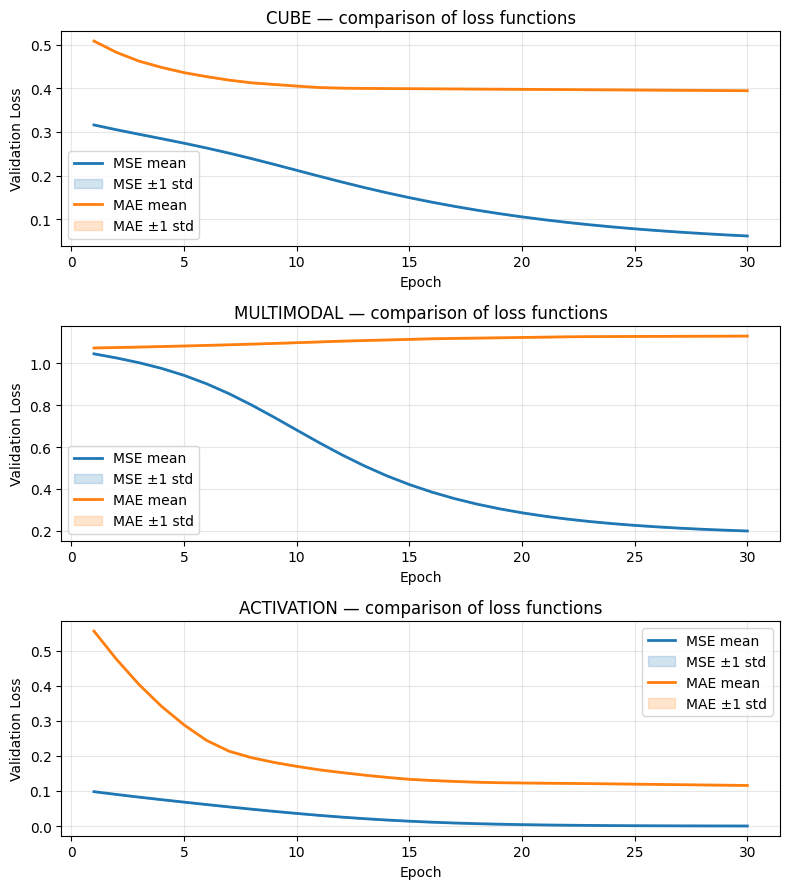

In [2]:
# Plotting: one plot per task, both loss functions on same axes
n_tasks = len(task_types)
fig, axes = plt.subplots(n_tasks, 1, figsize=(8, 3 * n_tasks), squeeze=False)

colors = ["C0", "C1"]
for ti, task in enumerate(task_types):
    ax = axes[ti, 0]
    for li, loss in enumerate(loss_funs):
        runs = histories[(task, loss)]  # shape (n_repeats, epochs)
        epochs_axis = np.arange(1, runs.shape[1] + 1)

        # faint individual runs
        for r in runs:
            ax.plot(epochs_axis, r, color=colors[li], alpha=0.15, linewidth=0.8)

        # mean and std
        mean = runs.mean(axis=0)
        std = runs.std(axis=0)
        ax.plot(epochs_axis, mean, color=colors[li], linewidth=2, label=f"{loss.name} mean")
        ax.fill_between(epochs_axis, mean - std, mean + std, color=colors[li], alpha=0.2, label=f"{loss.name} ±1 std")

    # ax.set_yscale("log")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Loss")
    ax.set_title(f"{task.name} — comparison of loss functions")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
